# Entanglement detection

In [1]:
## import necessary packages
import sys
import numpy as np
import math
from cmath import cos, sin, exp, pi, sqrt
import random

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
# Set the default color cycle
# mpl.rcParams['axes.prop_cycle'] = 
# https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
colors = mpl.cycler(color=["c", "m", "r", "g", "b"]) 
# colors = mpl.cycler(color=["c", "m", "y", "r", "g", "b"]) 
mpl.rc('axes', grid=False, edgecolor='k', prop_cycle=colors)

# import matplotlib.pyplot as plt
# plt.rc('font', size=12)          # controls default text sizes, default 10
# plt.rcParams['legend.edgecolor'] = "m"
# plt.rcParams['figure.dpi'] = 400
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from qutip import *

from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# import quantum_state_utils
from quantum_state_utils import *


## Entanglement witness

### Dataset generation and Visualize dataset samples

In [ ]:
size_train = 10
p_noise_limit = 1/2

# visualization
# fig = plt.figure(figsize=plt.figaspect(0.5))
fig = plt.figure(figsize=(12, 7))

# W3 with white noise
# GHZ3 with coherent noise
# cluster4 with coherent noise
sample_list = [
    rand_dm(N=4, dims=[[2, 2], [2, 2]]),
    random.choice(generate_bell_noisy_density(m=size_train,kind='11',noise_limit=p_noise_limit)),
    random.choice(generate_noisy_w_ensemble(3,size_train,p_noise_limit)),
    random.choice(generate_noisy_ghz_ensemble(3,size_train,p_noise_limit)),
    random.choice(generate_coherent_noisy_ghz_ensemble(n=3,m=1,theta_limit=1/2,phi_limit=0.6,p_limit=p_noise_limit)),
    random.choice(generate_noisy_biseparable(1, 2, size_train, 0)),
    # ket2dm(generate_linear_cluster(n=4))
]
# print(sample_list)

title_list = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
# title_list = ['(a) random density matrix', '(b) Bell state with white noise', '(c) W state with white noise', '(d) GHZ state with white noise', '(e) GHZ with coherent noise', '(f) 4-qubit linear cluster']

for index, sample in enumerate(sample_list):
    ax = fig.add_subplot(2, 3, index+1, projection='3d')
    ax.set_title(title_list[index], loc='left', fontsize=24)
    # ax.set_xlabel([])
    # xlabels=['00', '01', '10', '11'],
    # ax.tick_params(labelbottom=False)
    matrix_histogram(sample, fig=fig, ax=ax)

plt.savefig('dataset_sample_3x2.png', dpi=400, bbox_inches='tight')


### 2-qubti unfaithful

In [ ]:
# psi = tensor(basis(2, 0), basis(2, 1))
# print(psi)
# print(psi.ptrace(0))
# print(tensor(psi.ptrace(0),qeye([2])))

# faithfulness of 2-qubit
samples = generate_two_qubit_random_state_PPT(m=10000)

def x_d(rho, d):
    return rho - 1 / d * (tensor(rho.ptrace(0), qeye([d])) + tensor(qeye([d]),rho.ptrace(1))) + 2 / d**2 * qeye([d, d])

x_2_PPT = [ x_d(rho,2) for rho in samples[1] ]
x_2_NPT = [ x_d(rho,2) for rho in samples[0] ]

maximal_x_d_PPT_eigvals = [rho.eigenenergies(sort='high', eigvals=1) for rho in x_2_PPT]
maximal_x_d_NPT_eigvals = [rho.eigenenergies(sort='high', eigvals=1) for rho in x_2_NPT]
unfaithful_entangled = [e for e in maximal_x_d_NPT_eigvals if e <= 0.5]
faithful_entangled = [e for e in maximal_x_d_NPT_eigvals if e > 0.5]
print('number of unfaithful in entangled:', len(unfaithful_entangled))

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylabel('Number of occurrences')
ax.set_xlabel(r'maximal eigenvalue of $ \chi_2( \rho_{AB}) $')
ax.set_title('(c)', loc='left', fontsize=18)
# ax.set_xlabel(r'maximal eigenvalue of $ X_2( \rho_{AB})=\rho_{AB}-\frac{1}{2}(\rho_{A}\otimes I + I \otimes \rho_{B})+\frac{1}{2} I\otimes I $')
# ax.set_title('faithfulness of (random) 2-qubit')
ax.hist(np.array(maximal_x_d_PPT_eigvals), alpha=0.7, color=color_config['separable'], edgecolor='k')
ax.hist(np.array(unfaithful_entangled), alpha=0.7, color=color_config['unfaithful'], edgecolor='k')
ax.hist(np.array(faithful_entangled),alpha=0.7,color=color_config['entangled'], edgecolor='k')
# ax.hist(np.array(maximal_x_d_NPT_eigval), alpha=0.7)
ax.legend(['Separable (PPT, unfaithful)','Entangled (NPT) but unfaithful', 'Entangled (NPT) and faithful'])
plt.savefig('faithfulness_2_qubit.png', dpi=400,bbox_inches='tight')

## 2-qubit case

### Bell, CHSH inequalities as entanglement witness

the Bell inequality
$$ \langle a_0b_0, a_0b_0', a_0'b_0, a_0'b_0' \rangle$$
with $a_0=\sigma_x$, $a_0'=\sigma_x$, $b_0=(\sigma_x-\sigma_z)/\sqrt{2}$, and $b_0'=(\sigma_x+\sigma_z)/\sqrt{2}$

the CHSH inequality
$$ \langle \rangle$$

Mermin inequality
yyx+xyy+yxy+xxx

### PPT criterion, Fidelity witness, CHSH

In [ ]:
print([ppt_criterion(dm) for dm in generate_bell_like_pure_state(2)])
print(np.array([ ppt_criterion(state) for state in generate_rand_product_state(n=2,m=8) ]))

In [ ]:
a_0 = sigmaz()
a_1 = sigmax()
b_0 = (sigmax() - sigmaz() )/sqrt(2)
b_1 = (sigmax() + sigmaz())/sqrt(2)

bell_ansatz = [ tensor(a_0,a_1), tensor(a_1,b_0), tensor(a_1,b_1), - tensor(a_0,b_1) ]
bell_inequality = tensor(a_0,a_1) + tensor(a_1,b_0) + tensor(a_1,b_1) - tensor(a_0,b_1) 


In [ ]:
# determine to what extent white noise the Bell state is not entangled
size = 100
text = 'xx'
white_noise_list = [ i/size for i in range(size) ]
# white_noise_list
white_noise_bell00 = [ p * ket2dm(bell_state('00')) + (1 - p) / 4 * identity([2, 2])  for p in white_noise_list ]
# white_noise_bell00
# np.array([ppt_criterion(rho) for rho in white_noise_bell00]).flatten()
plt.plot(np.array([ppt_criterion(rho) for rho in white_noise_bell00]).flatten())
plt.plot(np.array([0 for i in range(size)]))
# plt.title(r'size: $ \langle  {{{}}} \rangle$'.format(text))
# plt.title(r'maximal eigenvalue of $ \chi_2( \rho_{AB}) $ {size}')

In [ ]:
lll = [1,34,56,74,3]
[item for index,item in enumerate(lll)]

### machine learning ansatz

In [ ]:
# training with the entries of the density matrix

size_train = 1000
size_test = 100
bell_noise = 2 / 3
print(f'noise limit: {bell_noise:.2f}')

bell00_noisy = generate_bell_noisy_density(size_train*2, '00', bell_noise)
# print(bell00_noisy_density[0])
bell01_noisy = generate_bell_noisy_density(size_train*2, '01', bell_noise)
bell10_noisy = generate_bell_noisy_density(size_train*2, '10', bell_noise)
bell11_noisy = generate_bell_noisy_density(size_train*2, '11', bell_noise)

bell_like_train = bell00_noisy[:size_train] + bell01_noisy[:size_train] + bell10_noisy[:size_train]+ bell11_noisy[:size_train]

two_product_states = generate_rand_product_density(n=2, m=len(bell_like_train))
# bell_like_train = bell00_noisy + bell01_noisy + bell10_noisy + bell11_noisy
bell_states_lables = [bell_like_train, const_label(0, len(bell_like_train))]

# two_qubit_product_states_train = generate_rand_product_state(n=2, m=len(bell_like_train))
two_product_states_lables = [ two_product_states, const_label(1, len(two_product_states)) ]

# two_pauli, two_label = tomographic_ansatz(n_qubit=2,n_feature=9)

X, y = construct_training_dataset(
    states_labels=[bell_states_lables, two_product_states_lables],
    operators=two_pauli_tomo_operators)

# (X, Y) = assemble_training_dataset(size_train)
to_features = 2
print(f'# tomographic features: {len(two_pauli_tomo_operators)}; selected features: {to_features}')

accuracy = 0.0
while accuracy < 0.99:
    select_indices = random.sample([i for i in range(len(two_pauli_tomo_operators))], to_features)
    select_labels  = two_pauli_tomo_labels[select_indices]
    print('selected Pauli operators:', select_labels)

    # non-linear kernel SVM
    witness, accuracy = svm_train_witness(X=X[:, select_indices], y=y, size_test=size_test)
    # linear kernel SVM with recursive feature elimination
    # witness, accuracy = svm_train_witness(X=X, y=y, size_test=size_test, kernel='linear', to_features=10)

bell_test_features = evaluate_features(operators=two_pauli_tomo_operators,states=bell_like_train[size_train:])
separable_test_features = evaluate_features(
    operators=two_pauli_tomo_operators,
    states=generate_rand_product_density(n=2, m=size_train))
two_qubit_ppt_state_features = evaluate_features(
    operators=two_pauli_tomo_operators, 
    states=generate_random_ppt_state(n_qubit=2,m=size_train))
two_qubit_npt_state_features = evaluate_features(
    operators=two_pauli_tomo_operators, 
    states=generate_random_npt_state(n_qubit=2,m=size_train))

test_expectation_lists = evaluate_witness(witness=witness, features_set=[bell_test_features[:, select_indices],separable_test_features[:, select_indices],two_qubit_ppt_state_features[:, select_indices]])

fig, ax = plt.subplots(figsize=(6, 4))
legends = ['bell states+white noise (ML)', 'separable states (ML)', 'PPT (ML)', 'bell inequality']
plot_expectation_hist(ax=ax, expectation_lists=test_expectation_lists, legends=legends, title='')
plt.savefig('two_qubit_bell_ml.png', dpi=300)

plot_feature_space(X=X, y=y, clf=witness, filter=select_indices, labels=select_labels, savefig=True)


In [ ]:
bell_test_size = 500
index_list = [i for i in range(bell_test_size)]
state_list = [
    generate_rand_product_density(n=2, m=bell_test_size),
    generate_random_ppt_state(n_qubit=2, m=bell_test_size),
    generate_bell_noisy_density(bell_test_size, '00', noise_limit=2 / 3),
    generate_bell_noisy_density(bell_test_size, '11', noise_limit=1 / 5),
    generate_random_npt_state(n_qubit=2, m=bell_test_size)
]
for states in state_list:
    plt.scatter(index_list, evaluate_features(operators=[tensor(sigmax(),sigmax())],states=states))
plt.legend(['2-qubit product states','2-qubit PPT states','Bell00','Bell11','NPT (entangled)'])

### distinguish bi-separable with entangled (2-qubit)

In [ ]:
size_train = 1000
train_score_list = []
test_score_list = []
sample_size_list = [200, 300, 600, 800, 1000]
for index, size_train in enumerate(sample_size_list):
    print(f'################ iteration {index}, size of training set: {size_train} ################')
    two_qubit_random_state_PPT = generate_two_qubit_random_state_PPT(size_train,plot=False)
    size = int(0.3*size_train)
    entangled_sample = [two_qubit_random_state_PPT[0][:size], const_label(0,size)]
    separable_sample = [two_qubit_random_state_PPT[1][:size], const_label(1,size)]

    # labels = [ const_label(0,len(entangled_sample)) , const_label(1,len(separable_sample)) ]

    states_labels = [entangled_sample, separable_sample]
    X,y = construct_training_dataset(states_labels=states_labels,operators=two_pauli)
    # X,y = construct_training_dataset(states=[entangled_sample,separable_sample],labels=labels,operators=two_pauli)
    train_score, test_score = my_svm(X=X, y=y, size_test=int(0.1*size_train), kernel='linear',legend=['zero','test - PPT','bell'],rfe=True)
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    # my_svm(X=X, y=y, size_test=100, kernel='rbf',legend=['zero','test - PPT','bell'])


plot_score(sample_size_list,train_score_list,test_score_list)


##### Two-qutrit, Two-qudit


In [ ]:
# qudit_basis()
x = basis(3, 2)
M = ket2dm(x)
print(M)

### Three-qubit case (fully separable, biseparable, GME, fully entanglement)

#### Different fidelity witness, different white noise limit (unfaithful)

In [ ]:
## compare projector witness and decomposition into local measurements
# print(3/2 * qeye([2, 2, 2]) - tensor([sigmax(), sigmax(), sigmax()]) - 1/2 * (tensor([sigmaz(), sigmaz(), qeye([2])]) + tensor([qeye([2]), sigmaz(), sigmaz()]) + tensor([sigmaz(), qeye([2]), sigmaz()])))
print(1/8 * (3*qeye([2, 2, 2]) - tensor([sigmax(), sigmax(), sigmax()]) - tensor([sigmaz(), sigmaz(), qeye([2])]) - tensor([qeye([2]), sigmaz(), sigmaz()]) - tensor([sigmaz(), qeye([2]), sigmaz()]) + tensor([sigmax(), sigmay(), sigmay()]) + tensor([sigmay(), sigmay(), sigmax()]) + tensor([sigmay(), sigmax(), sigmay()])  ))
print(1/2 * qeye([2, 2, 2]) - ket2dm(ghz_state(N=3)))

In [ ]:
size_train = 1000
size_test = 1000

# noise_limit = 1/5
to_features = 5

# three-qubit tomographic ansatz
# three_pauli = [tensor([a,b,c]) for a in pauli_operators for b in pauli_operators for c in pauli_operators]
# three_pauli = random.sample(three_pauli,to_features)
three_pauli, three_label = tomographic_ansatz(n_qubit=3,n_feature=to_features)


# rigorous entanglement witness - local measurements
## Detecting Genuine Multipartite Entanglement with Two Local Measurements
# witness_ghz_3 =  3/2 * qeye([2, 2, 2]) - tensor([sigmax(), sigmax(), sigmax()]) - 1/2 * (tensor([sigmaz(), sigmaz(), qeye([2])]) + tensor([qeye([2]), sigmaz(), sigmaz()]) + tensor([sigmaz(), qeye([2]), sigmaz()]))
witness_ghz_3 = 1/2 * qeye([2, 2, 2]) - ket2dm(ghz_state(N=3))
# witness_ghz_3_project = 1/2 * qeye([2, 2, 2]) - ket2dm(ghz_state(N=3))
# stabilizer ...

# rigorous entanglement witness - projection
witness_w_3_project = 2/3 * qeye([2, 2, 2]) - ket2dm(w_state(N=3))

# generate_noisy_biseparable(1,2,10,1/3)
# generate_rand_product_density(3,1,0)

# fig, ax = plt.subplots(figsize=(6, 4))
# fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
# ax0 = plt.subplot(1,2,1)
# ax1 = plt.subplot(1,2,2)
noise_list = [1/2]
theta_limit = 1/3
phi_limit = 0.6
# noise_list = [1/3, 1/2]
witness_list = [witness_ghz_3, witness_w_3_project]
x_labels = [r'Tr$(\rho W_{GHZ})$', r'Tr$(\rho W_W)$']
fig_labels = ['(a)', '(b)']
# print(len(noise_list))
fig, axs = plt.subplots(nrows=len(witness_list), ncols=len(noise_list), figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)
# plt.subplots_adjust(wspace=0.4, left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.4)

# for index, item in enumerate(ranking):
for i, noise_limit in enumerate(noise_list):
    for j, witness in enumerate(witness_list):
        ## generate training data
        # GHZ and W state samples with white noise
        ghz_3_density = generate_coherent_noisy_ghz_ensemble(n=3, m=size_train, theta_limit=theta_limit, phi_limit=phi_limit)
        # ghz_3_density = generate_noisy_ghz_ensemble(n=3,m=size_train,noise_limit=noise_limit)
        w_3_density = generate_noisy_w_ensemble(n=3,m=size_train,noise_limit=noise_limit)

        # test GHZ3/W3 projection witness
        three_qubit_legends = ['bi-separable','GHZ_3 with coherent noise','W_3 with white noise']
        # three_qubit_legends = ['fully separable','bi-separable','GHZ_3 with coherent noise','W_3 with white noise']
        three_qubit_witness_expectation_list = [
            evaluate_features(witness,test_set) for test_set in
            # [expect(witness_ghz_3, state) for state in test_set] for test_set in
            [
                # generate_rand_product_density(3, size_train, 0),
                generate_noisy_biseparable(1, 2, int(size_train/2), 0)+generate_noisy_biseparable(2, 1, int(size_train/2), 0),
                ghz_3_density,
                w_3_density
            ]
            # [generate_rand_product_state(3, size_train), ghz_3_density, w_3_density]
        ]
        if j == 0:
            title = f'GHZ witness (noise = {noise_limit:.2f})'
        else:
            title = f'W witness (noise = {noise_limit:.2f})'
        plot_expectation_hist(
            axs[j],
            # plot_expectation_hist(axs[j,i],
            three_qubit_witness_expectation_list,
            three_qubit_legends,
            # title=title,
            fontsize=16,
            xlabel=x_labels[j])
        axs[j].set_title(fig_labels[j], loc='left', fontsize=20)

plt.savefig('fidelity_witness_compare_2_long.png', dpi=400, bbox_inches='tight')

#### Unfaithful, ful entangle, GME: 3-qubit GHZ, W

In [ ]:
# determine to what extent white noise the Bell/GHZ/W state is not entangled
size = 1000
white_noise_list = [i / size for i in range(size)]
# white_noise_list
white_noise_www = [
    p * ket2dm(w_state(3)) + (1 - p) / 2**3 * qeye([2 for j in range(3)])
    for p in white_noise_list
]

white_noise_ghz = [
    p * ket2dm(ghz_state(3)) + (1 - p) / 2**3 * qeye([2 for j in range(3)])
    for p in white_noise_list
]

# evaluate the least eigenvalues of partial transpose with partition (A|BC)
eigvals_ghz = np.array([ppt_criterion(rho) for rho in white_noise_ghz]).flatten()
eigvals_www = np.array([ppt_criterion(rho) for rho in white_noise_www]).flatten()

def find_maximal_p_entangle(eigval_list):
    for index, item in enumerate(eigval_list):
        if index < size - 1:
            if item * eigval_list[index + 1] < 0:
                print('least eigenvale: ', item,'when p=', index/size)

find_maximal_p_entangle(eigvals_ghz)
find_maximal_p_entangle(eigvals_www)

plt.plot(white_noise_list, eigvals_ghz)
plt.plot(white_noise_list, eigvals_www)
plt.plot(white_noise_list, [3/8-7/8*p for p in white_noise_list])
plt.plot(white_noise_list, [13/24-21/24*p for p in white_noise_list])
plt.plot(white_noise_list, np.array([0 for i in white_noise_list]),'k--', label='_nolegend_')
plt.legend(['ghz_PPT','w_PPT','ghz_proj_witness','w_proj_witness','0'])
plt.xlabel('p')
plt.ylabel('least eigenvalue / Tr(W rho)')

### machine learning ansatz
#### Feature elimination
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py

generate_rand_product_density_matrix: 3 qubits, 4000 samples
generate_coherent_noisy_ghz_ensemble: n = 3, m = 4000, theta_limit = 0.50*pi, phi_limit = 0.60*pi, p_limit = 0.10
train score: 1.0000; test score: 1.0000; number of features: 63
selected Pauli operators: ['IXX' 'ZYX' 'ZZZ' 'ZZX' 'XXI' 'ZYI' 'YZX' 'ZIY' 'YXZ' 'IZX' 'IXZ' 'XII'
 'YZI' 'ZXZ' 'ZYY' 'XXY' 'IIX' 'XYI' 'YXY' 'IXI' 'ZZI' 'IIZ' 'XYX' 'IYZ'
 'ZXI' 'ZIZ' 'XZI' 'XXZ' 'IXY' 'YIZ' 'YZY' 'IZZ' 'YXI' 'XIX' 'XZZ' 'IYI'
 'XYZ' 'ZIX' 'YYZ' 'YXX' 'XIZ' 'IYX' 'XZX' 'ZXY' 'XYY' 'XZY' 'IYY' 'ZII'
 'YZZ' 'IIY' 'YYI' 'IZI' 'ZYZ' 'YII' 'YYY' 'ZZY' 'YYX' 'YIX' 'III' 'YIY'
 'XIY' 'XXX' 'ZXX']
train score: 1.0000; test score: 1.0000; number of features: 62
selected Pauli operators: ['ZYX' 'ZZZ' 'ZZX' 'XXI' 'ZYI' 'YZX' 'ZIY' 'YXZ' 'IZX' 'IXZ' 'XII' 'YZI'
 'ZXZ' 'ZYY' 'XXY' 'IIX' 'XYI' 'YXY' 'IXI' 'ZZI' 'IIZ' 'XYX' 'IYZ' 'ZXI'
 'ZIZ' 'XZI' 'XXZ' 'IXY' 'YIZ' 'YZY' 'IZZ' 'YXI' 'XIX' 'XZZ' 'IYI' 'XYZ'
 'ZIX' 'YYZ' 'YXX' 'XIZ' 'IYX' 'XZX' 'ZXY

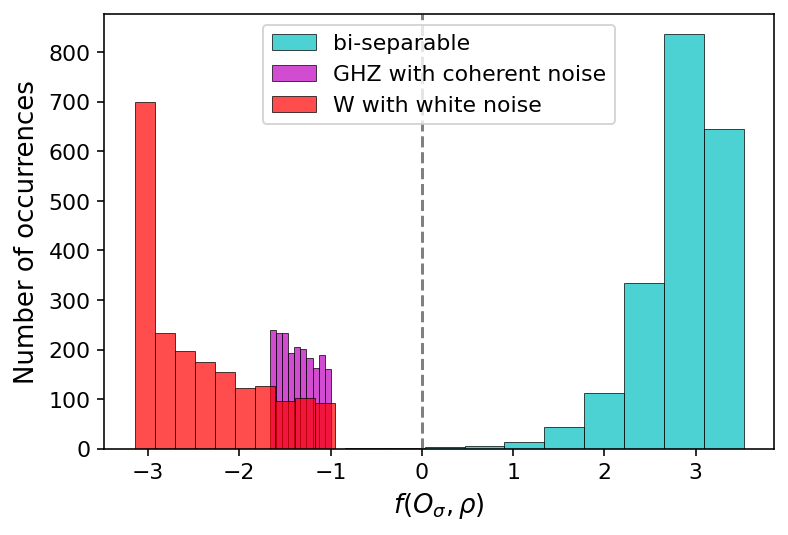

In [36]:
size_train = 2000
size_test = 1000
theta_limit = 0.5
phi_limit = 0.6
noise_limit = 1/2

##################### training ########################
# input_states = [generate_rand_product_state(3, 2 * size_train), ghz_3_density, w_3_density]
# labels = [ [1 for i in range(2 * size_train)], [0 for i in range(size_train) ], [0 for i in range(size_train)] ]
# print(labels)
fully_sep_state = generate_rand_product_state(n=3,m=size_train*2,noise_limit=0,is_pure=False)
bi_sep_state    = generate_noisy_biseparable(n_A=1,n_B=2, m=size_train,noise_limit=0) +  generate_noisy_biseparable(n_A=2,n_B=1, m=size_train,noise_limit=0)
random.shuffle(bi_sep_state)
ghz3_state = generate_coherent_noisy_ghz_ensemble(n=3, m=size_train*2, theta_limit=theta_limit, phi_limit=phi_limit,p_limit=0.1)
# ghz3_state      = generate_noisy_ghz_ensemble(n=3,m=size_train*2,noise_limit=noise_limit)
w3_state = generate_noisy_w_ensemble(n=3,m=size_train*2,noise_limit=noise_limit)

# label the states
fully_sep_data = [fully_sep_state[:size_train] , const_label(1, size_train) ]
bi_sep_data = [bi_sep_state[:size_train], const_label(1,size_train)]
ghz3_data = [ghz3_state[:size_train], const_label(0,size_train)]
w3_data = [w3_state[:size_train], const_label(0,size_train)]

# SVM
three_pauli_tomo_operators = pauli_tensor_observables(n_qubit=3)
three_pauli_tomo_labels = pauli_tensor_labels(n_qubit=3)
X, y = construct_training_dataset(
    states_labels=[bi_sep_data, ghz3_data, w3_data],
    operators=three_pauli_tomo_operators)

# (X, Y) = assemble_training_dataset(size_train)
to_features = 10
least_features = 3
# print(f'# randomly selected features: {to_features}')

# accuracy = 0.0
# while accuracy < 1:
#     select_indices = random.sample([i for i in range(len(three_pauli_tomo_operators))], to_features)
#     select_labels  = three_pauli_tomo_labels[select_indices]
#     print('selected Pauli operators:', select_labels)
#     # non-linear kernel SVM
#     witness, accuracy = svm_train_witness(X=X[:, select_indices], y=y, size_test=size_test)

accuracy = 0.0
select_indices = random.sample([i for i in range(len(three_pauli_tomo_operators))], len(three_pauli_tomo_operators))
# print(select_indices)
while accuracy < 0.999 or len(select_indices) > least_features:
    # print(accuracy)
    for i in range(len(select_indices)):
        # drop the i-th feature
        temp_select_indices = select_indices[:i] + select_indices[i+1 :]
        # print(temp_select_indices)
        witness, accuracy = svm_train_witness(X=X[:, temp_select_indices], y=y, size_test=size_test)
        if accuracy > 0.999:
            select_indices = temp_select_indices
            # print(select_indices)
            select_labels  = three_pauli_tomo_labels[select_indices]
            print('selected Pauli operators:', select_labels)
            break
        else:
            if  i==len(select_indices)-1:
                print("didn't find, restart")
                select_indices = random.sample([i for i in range(len(three_pauli_tomo_operators))], len(three_pauli_tomo_operators))


##################### testing ########################
# fully_sep_test = generate_rand_product_density(3, size_test)
fully_sep_test = fully_sep_state[size_train:]
bi_sep_test = bi_sep_state[size_train:]
ghz3_test = ghz3_state[size_train:]
w3_test = w3_state[size_train:]

test_dataset = [bi_sep_test, ghz3_test, w3_test]
# test_dataset = [fully_sep_test, bi_sep_test, ghz3_test, w3_test]

feature_test_set = [evaluate_features(operators=three_pauli_tomo_operators,states=data)[:,select_indices] for data in test_dataset]
test_expectation_lists = evaluate_witness(witness=witness, features_set=feature_test_set)


fig, ax = plt.subplots(figsize=(6, 4))
title = f'ML witness (noise = {noise_limit:.2f} )'
comparison_legend = ['bi-separable', 'GHZ with coherent noise', 'W with white noise']
# comparison_legend = ['fully separable (ML)', 'bi-separable (ML)', 'GHZ (ML)', 'W (ML)']
# three_qubit_legend = ['zero', 'fully separable (GHZ witness)', 'GHZ3 (GHZ witness)', 'W3 (GHZ witness)', 'fully separable (W witness)','W3 (W witness)', 'GHZ (W witness)', 'fully separable (ML)', 'GHZ (ML)', 'W (ML)']
plot_expectation_hist(ax, test_expectation_lists, comparison_legend, title='', xlabel=r'$f(O_{\sigma},\rho)$', legend_loc='upper center')

##################### plot ########################

# fig.show()
plt.savefig('three_qubit_hist_ML_3qubit.png', dpi=400, bbox_inches='tight')


results (found features):
['XZX' 'ZZX' 'ZIZ' 'IZZ' 'ZZZ']
['YYI' 'YYZ' 'ZIZ' 'IYI' 'IIX']
['ZZZ' 'ZIZ' 'YIZ' 'YZZ' 'IZZ']
['ZIZ' 'XIX' 'IIX' 'ZXI' 'ZZI']
['YIY' 'YZX' 'ZZI']

### 4-qubit case

generate_coherent_noisy_ghz_ensemble: n = 4, m = 10000, theta_limit = 0.50*pi, phi_limit = 0.60*pi, p_limit = 0.00
['IIXX', 'IIXY', 'IIXZ', 'IIYX', 'IIYY', 'IIYZ', 'IIZX', 'IIZY', 'IIZZ', 'IXIX', 'IXIY', 'IXIZ', 'IXXI', 'IXYI', 'IXZI', 'IYIX', 'IYIY', 'IYIZ', 'IYXI', 'IYYI', 'IYZI', 'IZIX', 'IZIY', 'IZIZ', 'IZXI', 'IZYI', 'IZZI', 'XIIX', 'XIIY', 'XIIZ', 'XIXI', 'XIYI', 'XIZI', 'XXII', 'XYII', 'XZII', 'YIIX', 'YIIY', 'YIIZ', 'YIXI', 'YIYI', 'YIZI', 'YXII', 'YYII', 'YZII', 'ZIIX', 'ZIIY', 'ZIIZ', 'ZIXI', 'ZIYI', 'ZIZI', 'ZXII', 'ZYII', 'ZZII']
train score: 1.0000; test score: 1.0000; number of features: 53
selected Pauli operators: ['YYII' 'IZXI' 'XXII' 'ZIYI' 'IXIZ' 'IZIX' 'YIZI' 'IIXY' 'IYYI' 'XYII'
 'IIZY' 'ZZII' 'IXZI' 'ZIIY' 'IYIZ' 'IIXZ' 'ZIXI' 'ZYII' 'YIIX' 'IXIX'
 'IZIZ' 'XIIZ' 'IXYI' 'IZZI' 'YIXI' 'XIIY' 'XZII' 'IIYY' 'ZIIX' 'YIYI'
 'IXIY' 'IYIY' 'IIYZ' 'IZYI' 'XIZI' 'IIXX' 'IYZI' 'XIXI' 'ZIIZ' 'IZIY'
 'YZII' 'YXII' 'YIIY' 'IIYX' 'ZIZI' 'IIZX' 'XIIX' 'IYXI' 'XIYI' 'IXXI'
 'YIIZ'

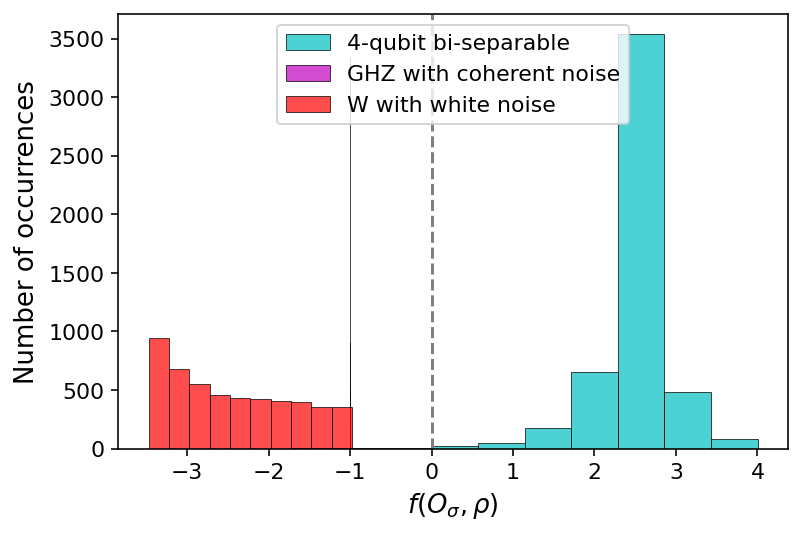

In [37]:
n_qubit = 4
size_train = 5000
size_test = 1000
theta_limit = 0.5
phi_limit = 0.6
white_noise_limit = 1/2

##################### prepare dataset #######################

bi_sep_state = generate_noisy_biseparable(n_A=1,n_B=n_qubit-1, m=size_train) + generate_noisy_biseparable(n_A=2,n_B=n_qubit-2, m=size_train)
random.shuffle(bi_sep_state)
ghz4_state = generate_coherent_noisy_ghz_ensemble(n=n_qubit, m=size_train*2, theta_limit=theta_limit, phi_limit=phi_limit,p_limit=0)
# ghz3_state      = generate_noisy_ghz_ensemble(n=3,m=size_train*2,noise_limit=noise_limit)
w4_state        = generate_noisy_w_ensemble(n=n_qubit,m=size_train*2,noise_limit=white_noise_limit)

# label the states: biseparable with y=1, entangled with y=0
bi_sep_data = [bi_sep_state[:size_train], const_label(1,size_train)]
ghz4_data = [ghz4_state[:size_train], const_label(0,size_train)]
w4_data = [w4_state[:size_train], const_label(0,size_train)]

# 2-local Pauli observables of 4-qubit states
# pauli_tomo_operators = pauli_tensor_observables(n_qubit=n_qubit)
# pauli_tomo_labels = pauli_tensor_labels(n_qubit=n_qubit)
tomo_pauli_strings = pauli_tensor_labels(n_qubit=4)
pauli_dict = {'I': identity(2), 'X': sigmax(), 'Y': sigmay(), 'Z': sigmaz()}
len(tomo_pauli_strings)
two_local_pauli_strings = []
for pauli_operator in tomo_pauli_strings:
    if [*pauli_operator].count('I') == 2:
        two_local_pauli_strings.append(pauli_operator)
print(two_local_pauli_strings)
two_local_pauli_strings = np.array(two_local_pauli_strings)
two_local_pauli_operators = [tensor([pauli_dict[p] for p in list(string)]) for string in two_local_pauli_strings]
# print(two_local_pauli_operators[9])
# print(two_local_pauli_operators)
X, y = construct_training_dataset(
    states_labels=[bi_sep_data, ghz4_data, w4_data],
    operators=two_local_pauli_operators)

##################### training ########################
to_features = 10
least_features = 4
# print(f'# randomly selected features: {to_features}')

# SVM
accuracy = 0.0
select_indices = random.sample([i for i in range(len(two_local_pauli_operators))], len(two_local_pauli_operators))
# print(select_indices)
while accuracy < 0.999 or len(select_indices) > least_features:
    # print(accuracy)
    for i in range(len(select_indices)):
        # drop the i-th feature
        temp_select_indices = select_indices[:i] + select_indices[i+1 :]
        # print(temp_select_indices)
        witness, accuracy = svm_train_witness(X=X[:, temp_select_indices], y=y, size_test=size_test)
        if accuracy > 0.999:
            select_indices = temp_select_indices
            # print(select_indices)
            select_labels = two_local_pauli_strings[select_indices]
            print('selected Pauli operators:', select_labels)
            break
        else:
            if  i==len(select_indices)-1:
                print("didn't find, restart")
                select_indices = random.sample(
                    [i for i in range(len(two_local_pauli_operators))],
                    len(two_local_pauli_operators))


##################### testing ########################
bi_sep_test = bi_sep_state[size_train:]
ghz4_test = ghz4_state[size_train:]
w4_test = w4_state[size_train:]

test_dataset = [bi_sep_test, ghz4_test, w4_test]

feature_test_set = [
    evaluate_features(operators=two_local_pauli_operators,
                      states=data)[:, select_indices] for data in test_dataset
]
test_expectation_lists = evaluate_witness(witness=witness, features_set=feature_test_set)

fig, ax = plt.subplots(figsize=(6, 4))
title = f'ML witness (noise = {white_noise_limit:.2f} )'
comparison_legend = ['4-qubit bi-separable', 'GHZ with coherent noise', 'W with white noise']

plot_expectation_hist(ax, test_expectation_lists, comparison_legend, title='', xlabel=r'$f(O_{\sigma},\rho)$', legend_loc='upper center')

##################### plot ########################

# fig.show()
plt.savefig('three_qubit_hist_ML_4qubit.png', dpi=400, bbox_inches='tight')

['ZIYY' 'IXII' 'IZZI' 'YZYY' 'ZIZZ']
['IIZZ' 'IIXI' 'YYZZ' 'YIII' 'IYZX']
['ZZII' 'IXIX' 'IYYI' 'IYIY']

### Non-stabilizer: W state, sqrt(SWAP)
### different partitions
[TODO]

### Unfaithful state - large white noise, coherent noise (local U)
#### W state, four qubit linear cluster state


In [ ]:
cluster_4 = generate_linear_cluster(n=4)
# print(cluster_4)

# stabilizer - two local measurement setting
# xzxzxzxz

# print((tensor(plus_state, zero_state, zero_state, plus_state) +
#        tensor(plus_state, zero_state, one_state, minus_state) +
#        tensor(minus_state, one_state, zero_state, plus_state) -
#        tensor(minus_state, one_state, one_state, minus_state)) / 2 - cluster_4)

#### More qubit case

2D cluster state
....

## Versions of software package/module 

In [ ]:
# about()
# conda list
# from qutip.ipynbtools import version_table
# version_table()
# qutip.cite()

print('numpy version:', np.__version__)
print('matplotlib version', mpl.__version__)

import sklearn
print('Scikit-learn version:', sklearn.__version__)
print('QuTiP version:', qutip.__version__)